# LightGBM

## Навигация

- [Оптимизация гиперпараметров с кросс-валидацией](#Оптимизация-гиперпараметров-с-кросс-валидацией)
- [Refit на всём X_train](#Refit-на-всём-X_train)
- [Perfomance на X_test](#Perfomance-на-X_test)
- [Perfomance на X_train](#Perfomance-на-X_train)
- [SHAP values](#SHAP-values)
- [Permutation Importance](#Permutation-Importance)

In [1]:
import os
import sys
sys.path.append('..')
from typing import Dict

import lightgbm
import optuna
import pandas as pd
import shap

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.inspection import permutation_importance

from my_ds_tools.classification import my_multiclass_classification_report
from my_ds_tools.interpretation import permutation_importance_plot
import src

In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_columns', None)

In [3]:
TRAIN_DATA_PATH = os.path.join('..', 'data', 'processed', 'train_data.csv')
TEST_DATA_PATH = os.path.join('..', 'data', 'processed', 'test_data.csv')

N_TRIALS = 50

CAT_FEATURES = sorted(list(src.constants.CATEGORICAL_FEATURES))
FEATURES_TO_IMPUT = [src.constants.QUESTION_2]
USEFUL_FOR_IMPUT = [
    src.constants.QUESTION_6, src.constants.QUESTION_8, src.constants.QUESTION_31,
    src.constants.QUESTION_32, src.constants.QUESTION_33, src.constants.QUESTION_34,
    src.constants.QUESTION_35,
]

In [4]:
CAT_FEATURES = ['3', '23', '25']
FEATURES_TO_IMPUT = ['2']
USEFUL_FOR_IMPUT = ['6', '8', '31', '32', '33', '34', '35']

In [5]:
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

X_train = train_data.drop(columns=src.constants.TARGET)
X_test = test_data.drop(columns=src.constants.TARGET)
y_train = train_data[src.constants.TARGET]
y_test = test_data[src.constants.TARGET]

for df in [X_train, X_test]:
    df.rename(
        columns={
            '2. Возраст': '2',
            '3. Семейное положение': '3',
            '4. Если имеете супруга или партнера, как долго вы живете вместе (в годах)?': '4',
            '5. В какой семье Вы выросли?': '5',
            '6. Жив ли хотя бы один из Ваших родителей (да/нет)?': '6',
            '7. Если да, как часто вы общаетесь?': '7',
            '8. Есть ли у Вас дети (да/нет)?': '8',
            '9. Если да, сколько?': '9',
            '10. Есть ли у Вас совершеннолетние дети (да/нет)?': '10',
            '11. Если да, как часто вы общаетесь?': '11',
            '12. Сколько человек живут вместе с Вами?': '12',
            '13. Каковы Ваши взаимоотношения с соседями?': '13',
            '14. Как часто Вы встречаетесь с друзьями?': '14',
            '15. Есть ли у Вас домашние питомцы (да/нет)?': '15',
            '16. В течение последних 7 дней, как часто Вы практиковали тяжелые физические нагрузки?': '16',
            '17. В течение последних 7 дней, как часто Вы практиковали умеренные физические нагрузки?': '17',
            '18. В течение последних 7 дней, как часто Вы ходили пешком минимум 10 минут без перерыва?': '18',
            '19. Уровень Вашего образования?': '19',
            '20. Каков уровень образования Вашего партнера (если применимо)?': '20',
            '22. Как долго Вы проживаете в этом месте (в годах)?': '22',
            '23. Каков тип Вашего дома?': '23',
            '24. Если Вы живете в многоквартирном доме, то на каком этаже?': '24',
            '25. Каким транспортом Вы обычно пользуетесь?': '25',
            '26. Сколько времени занимает Ваш путь до работы в одну сторону?': '26',
            '27. Каков тип Вашей занятости?': '27',
            '28. Каковы Ваши предпочтения в пище?': '28',
            '29. Каков тип Вашего питания?': '29',
            '30. Вы курите (да/нет)?': '30',
            '31. Количество родов': '31',
            '32. Количество прерванных беременностей': '32',
            '33. Гинекологические заболевания (да/нет)': '33',
            '34. Заболевания щитовидной железы (да/нет)': '34',
            '35. Наследственность (да/нет)': '35',
        },
        inplace=True,
    )

In [6]:
for cat_feature in CAT_FEATURES:
    X_train[cat_feature] = X_train[cat_feature].astype('category')
    X_test[cat_feature] = X_test[cat_feature].astype('category')

## Оптимизация гиперпараметров с кросс-валидацией

In [7]:
def objective(trial: optuna.trial.Trial) -> float:
    """Целевая функция для оптимизации гиперпараметров."""
    model = get_model(trial, mode='fit')

    scores = cross_val_score(
        estimator=model,
        X=X_train,
        y=y_train,
        scoring='accuracy',
        cv=LeaveOneOut(),
        n_jobs=-1,
    )

    return scores.mean()


def get_model(trial: optuna.trial.Trial, mode: str) -> sklearn.pipeline.Pipeline:

    preprocessing = ColumnTransformer(
        transformers=[
            ('knn_imputer', KNNImputer(), FEATURES_TO_IMPUT + USEFUL_FOR_IMPUT),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False,
    ).set_output(transform='pandas')

    lgbm_model = lightgbm.LGBMClassifier(**get_init_hyperparams(trial, mode))

    pipe = Pipeline([
        ('preprocessing', preprocessing),
        ('lgbm', lgbm_model),
    ])

    return pipe


def get_init_hyperparams(trial: optuna.trial.Trial, mode: str) -> Dict:

    match mode:
        case 'fit':
            # Core Parameters
            num_leaves = trial.suggest_int('num_leaves', 2, 16)
            # Learning Control Parameters
            max_depth = trial.suggest_int('max_depth', 1, 5)
            min_split_gain = trial.suggest_float('min_split_gain', .01, .25)
            min_child_samples = trial.suggest_int('min_child_samples', 20, 100)
        case 'refit':
            # Core Parameters
            num_leaves = trial.params['num_leaves']
            # Learning Control Parameters
            max_depth = trial.params['max_depth']
            min_split_gain = trial.params['min_split_gain']
            min_child_samples = trial.params['min_child_samples']
        case _:
            assert False, 'ABOBA'

    init_hyperparams = dict(
        # Core Parameters
        objective='multiclass',
        boosting_type='gbdt',
        n_estimators=25,
        learning_rate=.05,
        num_leaves=num_leaves,
        n_jobs=-1,
        random_state=src.constants.RANDOM_STATE,

        # Learning Control Parameters
        max_depth=max_depth,
        min_split_gain=min_split_gain,
        min_child_samples=min_child_samples,
        verbose=-1,

        categorical_features=CAT_FEATURES,
    )

    return init_hyperparams

In [8]:
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=src.constants.RANDOM_STATE),
    direction='maximize',
    study_name='lgbm',
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
print('Лучшие гиперпараметры:')
for hyperparam, value in study.best_trial.params.items():
    print(f'* {hyperparam}: {value}')
print(f'Лучший mean Accuracy: {study.best_trial.value}')

Лучшие гиперпараметры:
* num_leaves: 16
* max_depth: 2
* min_split_gain: 0.17279224825247272
* min_child_samples: 67
Лучший mean Accuracy: 0.6383838383838384


## Refit на всём X_train

[К навигации](#Навигация)

In [10]:
model = get_model(study.best_trial, mode='refit')
model.fit(X_train, y_train)

[LightGBM] [Warning] categorical_feature is set with categorical_column=8,25,27, categorical_features=3,23,25 will be ignored. Current value: categorical_feature=8,25,27
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 495, number of used features: 32
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.092570
[LightGBM] [Info] Start training from score -1.104691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

categorical_features in param dict is overridden.


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('knn_imputer', KNNImputer(),
                                                  ['2', '6', '8', '31', '32',
                                                   '33', '34', '35'])],
                                   verbose_feature_names_out=False)),
                ('lgbm',
                 LGBMClassifier(categorical_features=['3', '23', '25'],
                                learning_rate=0.05, max_depth=2,
                                min_child_samples=67,
                                min_split_gain=0.17279224825247272,
                                n_estimators=25, n_jobs=-1, num_leaves=16,
                                objective='multiclass', random_state=42))])

## Perfomance на X_train

[К навигации](#Навигация)

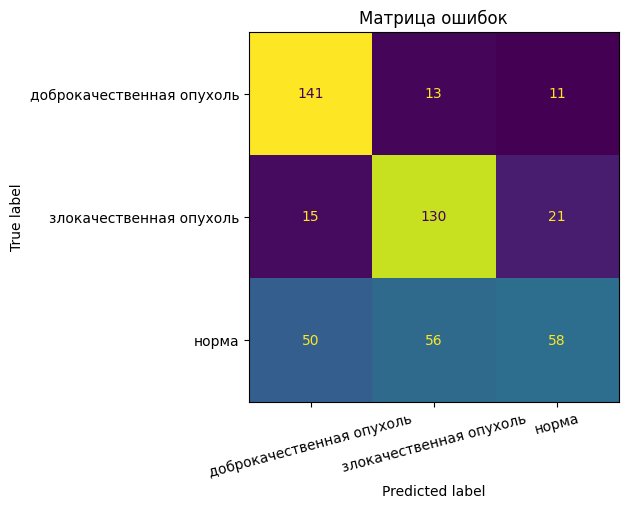

                           precision    recall  f1-score   support

доброкачественная опухоль       0.68      0.85      0.76       165
  злокачественная опухоль       0.65      0.78      0.71       166
                    норма       0.64      0.35      0.46       164

                 accuracy                           0.66       495
                macro avg       0.66      0.66      0.64       495
             weighted avg       0.66      0.66      0.64       495



In [11]:
my_multiclass_classification_report(
    model, X_train, y_train, cm_kw=dict(xticks_rotation=15))

## Perfomance на X_test

[К навигации](#Навигация)

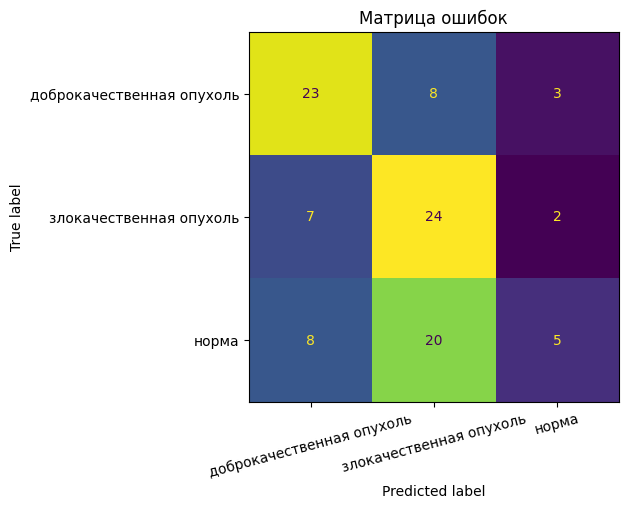

                           precision    recall  f1-score   support

доброкачественная опухоль       0.61      0.68      0.64        34
  злокачественная опухоль       0.46      0.73      0.56        33
                    норма       0.50      0.15      0.23        33

                 accuracy                           0.52       100
                macro avg       0.52      0.52      0.48       100
             weighted avg       0.52      0.52      0.48       100



In [12]:
my_multiclass_classification_report(
    model, X_test, y_test, cm_kw=dict(xticks_rotation=15))

## SHAP values

[К навигации](#Навигация)

In [13]:
lgbm_model = model.named_steps['lgbm']
preprocessing = model.named_steps['preprocessing']

In [14]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(preprocessing.transform(X_train))

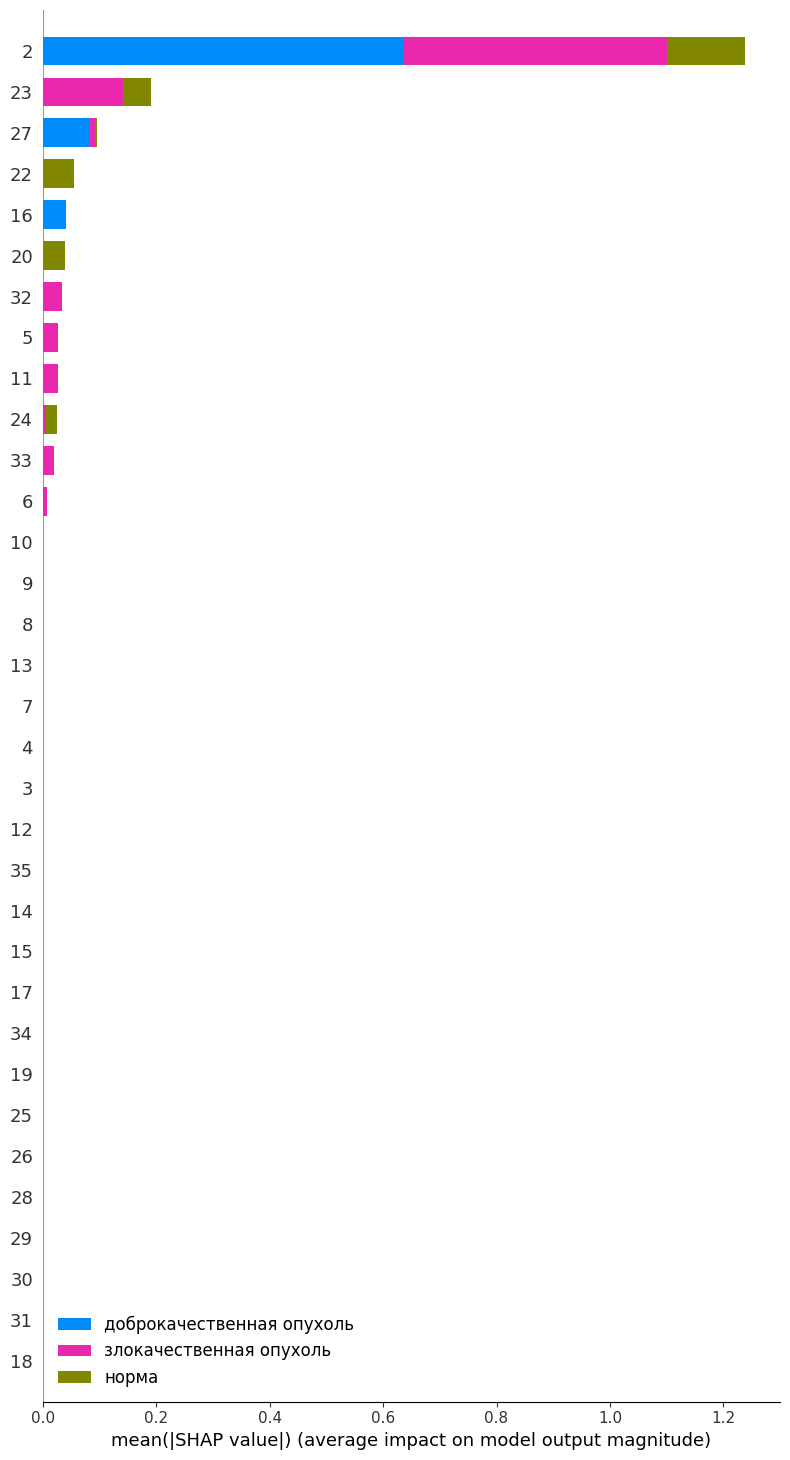

In [15]:
shap.summary_plot(
    shap_values=shap_values,
    features=X_train,
    class_names=['доброкачественная опухоль', 'злокачественная опухоль', 'норма'],
    max_display=33,
)

## Permutation Importance

[К навигации](#Навигация)

In [16]:
pi = permutation_importance(
    estimator=model,
    X=X_train,
    y=y_train,
    scoring='accuracy',
    n_repeats=1000,
    n_jobs=-1,
    random_state=src.constants.RANDOM_STATE,
)

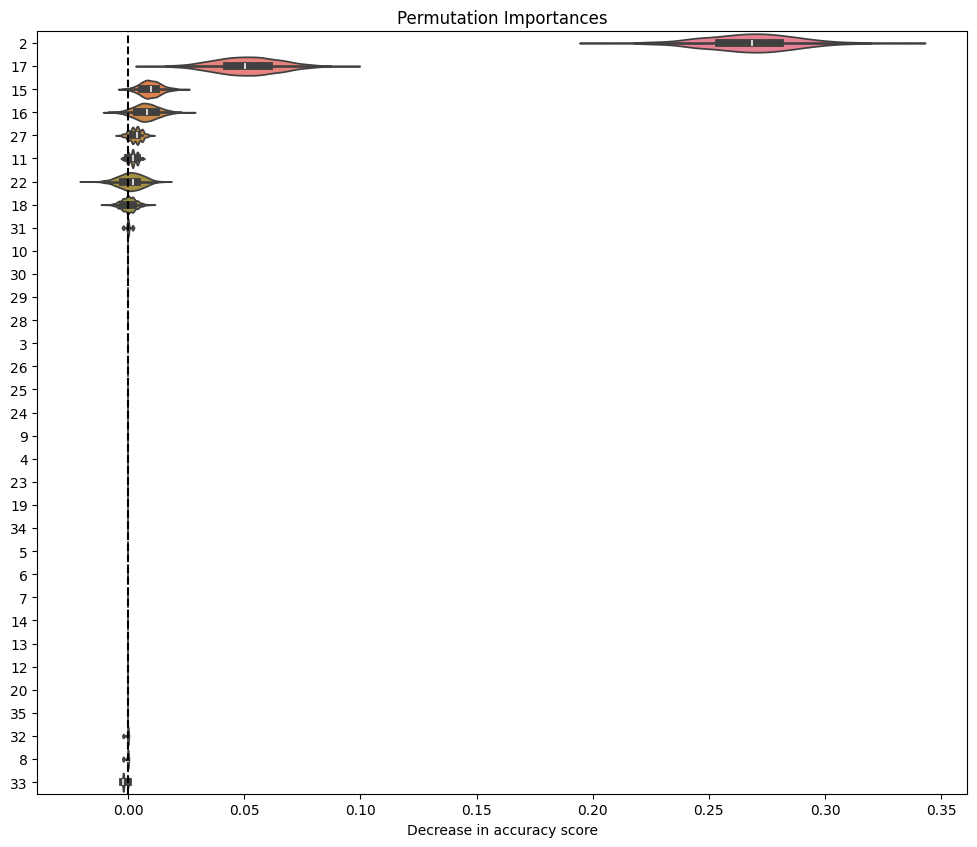

In [17]:
fig, ax = permutation_importance_plot(pi, X_train.columns)